# Prediction of Churn in a Mobile Operator's Customers

The communication operator "Neverbreak.com" wants to learn how to predict customer churn. If it turns out that a user plans to leave, they will be offered promo codes and special conditions. The operator's team has collected personal data on some customers, as well as information about their tariffs and contracts.

### Service Description

The operator provides two main types of services:

1. Fixed-line telephony. It is possible to connect a telephone set to several lines at the same time.
2. Internet. Connection can be of two types: via a *telephone line* (DSL, short for digital subscriber line) or via *fiber-optic cable*.

Other services are also available:

- Internet security: antivirus (*DeviceProtection*) and blocking of unsafe sites (*OnlineSecurity*);
- Dedicated technical support line (*TechSupport*);
- Cloud storage for data backup (*OnlineBackup*);
- Streaming TV (*StreamingTV*) and movie catalog (*StreamingMovies*).

Customers can pay for services each month or sign a contract for 1-2 years. Various payment methods are available, as well as the option to receive an electronic receipt.

Information about contracts is up to date as of February 1, 2020.

### Goal

Build a model that will most accurately predict whether a customer will leave the operator or not. This way, the communication operator will be able to save a significant amount of money since attracting new customers is more expensive than retaining old ones.

The key metric is **AUC-ROC, threshold value - 0.85**.

To control for randomness, I will set the parameter **random_state = 130223**.

## Data Preparation

I will import the necessary libraries, set the required options and constants.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import lightgbm as lgb
import seaborn as sns
import phik

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.utils import shuffle
from phik import resources, report

pd.set_option('display.max_columns', 30)
warnings.simplefilter('ignore')

SEED = 130223
THRESHOLD_AUC_ROC = .85

Let's save the data into data frames.

In [37]:
try:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')
    
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Data is composed of files obtained from different sources:
- `contract.csv` - contract information
- `personal.csv` - personal client data
- `internet.csv` - internet service information
- `phone.csv` - phone service information

Let's review the description of the data fields:
- `BeginDate` - the date when services started to be used
- `EndDate` - the date when services ended to be used
- `Type` - contract type: monthly, yearly, etc.
- `PaperlessBilling` - whether a client is billed through electronic mail
- `PaymentMethod` - payment method
- `MonthlyCharges` - monthly expenses on services
- `TotalCharges` - total amount of money spent on services
- `Senior Citizen` - whether a client has a pension status based on age
- `Partner` - whether a client has a spouse
- `Dependents` - whether a client has dependents
- `MultipleLines` - whether a client has the ability to have parallel lines during a call

Let's output general information about each dataframe, as well as its first and last 5 rows.

In [38]:
dfs = [contract, personal, internet, phone]
dfs_names = ['contract', 'personal', 'internet', 'phone']

for df, df_name in zip(dfs, dfs_names):
    print(df_name)
    print()
    print(df.info())
    display(df)

contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


personal

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


phone

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Output from data exploration:

- Each dataframe has a customerID key.
- There are no missing values in the dataframes.
- Each dataframe requires serious data preprocessing, from correcting column names to changing data types.
- Most of the data in the dataframes carry Boolean information (but the data type should be int for convenience in machine learning).
- 4 columns should have (and have) the object format, 2 columns should have the float format, and 1 column should have the datetime format.

For the convenience of further data analysis, it is necessary to merge the dataframes by the customerID key. However, before that, it is necessary to check for duplicate values in the customerID key of each dataframe.

In [39]:
for df, df_name in zip(dfs, dfs_names):
    print(f'The number of duplicates in the customerID column of the dataframe {df_name} is', 
          df['customerID'].duplicated().sum())
    print()

The number of duplicates in the customerID column of the dataframe contract is 0

The number of duplicates in the customerID column of the dataframe personal is 0

The number of duplicates in the customerID column of the dataframe internet is 0

The number of duplicates in the customerID column of the dataframe phone is 0



I merge the tables now.

In [40]:
df = contract.merge(personal, on='customerID', how='outer')
df = df.merge(internet, on='customerID', how='outer')
df = df.merge(phone, on='customerID', how='outer')

Let's examine the resulting dataframe.

In [41]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


The length of the dataframe equals the length of the first two tables, which were used to create it - contract and personal. This means that there were no customerID keys in the internet and phone tables that were not present in contract and personal.

## Data preprocessing

### Renaming columns

Let's rename the columns to match Python naming style.

In [42]:
df.columns = ['id', 'begin_date', 'end_date', 'contract_type', 'e_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

### Adding a target feature column

The target feature for our analysis is whether a person stopped being a customer of the operator or not. This can be determined from the values in the end_date column: if a date is specified there, it means that the customer has left the operator. Let's examine the values in this column.

In [43]:
df['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

We'll add a column to the dataframe.

In [44]:
df['exited'] = (df['end_date'] != "No").astype("int")

### Handling missing values

Let's output the number of missing values in each column.

In [45]:
df.isna().sum()

id                      0
begin_date              0
end_date                0
contract_type           0
e_billing               0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
exited                  0
dtype: int64

There are missing values in 8 columns, with 7 of them having the same number of missing values. Let's examine the columns.

In [46]:
df

,id,begin_date,end_date,contract_type,e_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,1


All columns with missing values, except for internet_service, carry Boolean information.

Let's display the values of these columns by popularity.

In [47]:
gap_cols = ['internet_service', 'online_security', 'online_backup', 
            'device_protection', 'tech_support', 'streaming_tv', 
            'streaming_movies', 'multiple_lines']

for col in gap_cols:
    print(col)
    print()
    print(df[col].value_counts())
    print()
    print()

internet_service

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64


online_security

No     3498
Yes    2019
Name: online_security, dtype: int64


online_backup

No     3088
Yes    2429
Name: online_backup, dtype: int64


device_protection

No     3095
Yes    2422
Name: device_protection, dtype: int64


tech_support

No     3473
Yes    2044
Name: tech_support, dtype: int64


streaming_tv

No     2810
Yes    2707
Name: streaming_tv, dtype: int64


streaming_movies

No     2785
Yes    2732
Name: streaming_movies, dtype: int64


multiple_lines

No     3390
Yes    2971
Name: multiple_lines, dtype: int64




There is no class imbalance or any other patterns found.

Let's check if there is any relationship between the target feature and the values in the columns with missing values.

In [48]:
for col in gap_cols:
    print(col)
    print()
    print(df.groupby(['exited', col])['id'].count());
    print()
    print()

internet_service

exited  internet_service
0       DSL                 1962
        Fiber optic         1799
1       DSL                  459
        Fiber optic         1297
Name: id, dtype: int64


online_security

exited  online_security
0       No                 2037
        Yes                1724
1       No                 1461
        Yes                 295
Name: id, dtype: int64


online_backup

exited  online_backup
0       No               1855
        Yes              1906
1       No               1233
        Yes               523
Name: id, dtype: int64


device_protection

exited  device_protection
0       No                   1884
        Yes                  1877
1       No                   1211
        Yes                   545
Name: id, dtype: int64


tech_support

exited  tech_support
0       No              2027
        Yes             1734
1       No              1446
        Yes              310
Name: id, dtype: int64


streaming_tv

exited  streaming_tv
0      

No dependencies were found.

Let's examine some rows with missing values to determine if there is a relationship with other columns.

In [49]:
df[df['internet_service'].isna()]

,id,begin_date,end_date,contract_type,e_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
11,7469-LKBCI,2018-10-01,No,Two year,No,Credit card (automatic),18.95,326.8,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
16,8191-XWSZG,2015-10-01,No,One year,No,Mailed check,20.65,1022.95,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
21,1680-VDCWW,2019-02-01,No,One year,No,Bank transfer (automatic),19.80,202.25,Male,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
22,1066-JKSGK,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,20.15,20.15,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,1
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.2,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7017,4807-IZYOZ,2015-11-01,No,Two year,No,Bank transfer (automatic),20.65,1020.75,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
7019,9710-NJERN,2016-11-01,No,Two year,No,Mailed check,20.15,826,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
7020,9837-FWLCH,2019-02-01,No,Month-to-month,Yes,Electronic check,19.20,239,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
7030,0871-OPBXW,2019-12-01,No,Month-to-month,Yes,Mailed check,20.05,39.25,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0


In [50]:
df[df['multiple_lines'].isna()]

,id,begin_date,end_date,contract_type,e_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN,0
20,8779-QRDMV,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,39.65,39.65,Male,1,No,No,DSL,No,No,Yes,No,No,Yes,NaN,1
27,8665-UTDHZ,2019-11-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,30.20,30.2,Male,0,Yes,Yes,DSL,No,Yes,No,No,No,No,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,4501-VCPFK,2017-12-01,No,Month-to-month,No,Electronic check,35.75,1022.5,Male,0,No,No,DSL,No,No,Yes,Yes,No,No,NaN,0
7007,2274-XUATA,2014-02-01,No,Two year,Yes,Bank transfer (automatic),63.10,4685.55,Male,1,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,NaN,0
7029,2235-DWLJU,2019-08-01,No,Month-to-month,Yes,Electronic check,44.40,263.05,Female,1,No,No,DSL,No,No,No,No,Yes,Yes,NaN,0
7036,7750-EYXWZ,2019-02-01,No,One year,No,Electronic check,60.65,743.3,Female,0,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,NaN,0


No dependencies were found.

It can only be noted that the 7 columns with the same number of missing values appear to have missing values in the same rows. The column with fewer missing values - multiple_lines - has many missing values in other rows.

In this case, I conclude that:
- It is not possible to fill missing values in the internet_service column with real data. In this case, I will fill in the missing values with the value 'No'.
- The missing values in all other columns carry the informational value False - I will fill them with similar object-type values of 'No', and then, if necessary, process them at the stage of changing data types.

In [51]:
for col in gap_cols:
    df[col] = df[col].fillna('No')

### Changing the data types of columns.

Let's display general information about the dataframe and its first 5 rows.

In [52]:
df.info()

display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   contract_type      7043 non-null   object 
 4   e_billing          7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

,id,begin_date,end_date,contract_type,e_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


**I will change the data type to datetime** for begin_date and end_date.

In [53]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

If I change the data type in the end_date column and forcibly replace incorrect values, I will end up with many missing values.

When examining the first few rows, it becomes clear that the data is dated February 1, 2020. This is apparent from the values in the monthly_charges and total_charges columns - dividing the latter by the former gives the number of months since the customer's service start date.

Thus, before changing the data type in the end_date column, I will replace 'No' values with '2020-02-01 00:00:00'."

In [54]:
df.loc[(df['end_date'] == 'No'), 'end_date'] = '2020-02-01 00:00:00'

df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d %H:%M:%S')

**There is data in the dataframe that carries boolean type information. The values of such columns should be standardized**.

First, let's study the values of the columns.

In [55]:
bool_cols = ['e_billing', 'senior_citizen', 'partner', 
                'dependents', 'online_security', 'online_backup', 
                'device_protection', 'tech_support', 'streaming_tv', 
                'streaming_movies', 'multiple_lines', 'exited']

for col in bool_cols:
    print(col)
    print()
    print(df[col].value_counts())
    print()
    print()

e_billing

Yes    4171
No     2872
Name: e_billing, dtype: int64


senior_citizen

0    5901
1    1142
Name: senior_citizen, dtype: int64


partner

No     3641
Yes    3402
Name: partner, dtype: int64


dependents

No     4933
Yes    2110
Name: dependents, dtype: int64


online_security

No     5024
Yes    2019
Name: online_security, dtype: int64


online_backup

No     4614
Yes    2429
Name: online_backup, dtype: int64


device_protection

No     4621
Yes    2422
Name: device_protection, dtype: int64


tech_support

No     4999
Yes    2044
Name: tech_support, dtype: int64


streaming_tv

No     4336
Yes    2707
Name: streaming_tv, dtype: int64


streaming_movies

No     4311
Yes    2732
Name: streaming_movies, dtype: int64


multiple_lines

No     4072
Yes    2971
Name: multiple_lines, dtype: int64


exited

0    5174
1    1869
Name: exited, dtype: int64




I will process the values 'No' and 'Yes'.

In [56]:
for col in bool_cols:
    if df.loc[0, col] in ['No','Yes']:
        df[col] = df[col].replace(['Yes', 'No'], [1, 0])

**Change the data type to float**: total_charges.

In [57]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

Again, output general information about the dataframe.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   contract_type      7043 non-null   object        
 4   e_billing          7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   int64         
 11  dependents         7043 non-null   int64         
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   int64         
 14  online_b

After the transformations, there are missing values in the total_charges column.

Let's study and process them.

In [59]:
df[df['total_charges'].isna()]

,id,begin_date,end_date,contract_type,e_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52.55,NaN,Female,0,1,1,DSL,1,0,1,1,1,0,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20.25,NaN,Male,0,0,1,No,0,0,0,0,0,0,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80.85,NaN,Female,0,1,1,DSL,1,1,1,0,1,1,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25.75,NaN,Male,0,1,1,No,0,0,0,0,0,0,1,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56.05,NaN,Female,0,1,1,DSL,1,1,1,1,1,0,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19.85,NaN,Male,0,1,1,No,0,0,0,0,0,0,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25.35,NaN,Male,0,1,1,No,0,0,0,0,0,0,1,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20.00,NaN,Female,0,1,1,No,0,0,0,0,0,0,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19.70,NaN,Male,0,1,1,No,0,0,0,0,0,0,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73.35,NaN,Female,0,1,1,DSL,0,1,1,1,1,0,1,0


The presence of missing values is due to the fact that for customers, the current month is the month of connection, and therefore payment has not yet been made. By the way, the data above indicates the correctness of the calculation of the current date.

Replace missing values with 0.

In [60]:
df['total_charges'] = df['total_charges'].fillna(0)

For convenience in further machine learning (so as not to encode data for the LightGBM model), **change the data type from object to category**.

In [61]:
for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype('category')

### Anomaly processing

Let's output a histogram for each numerical column of the dataframe.

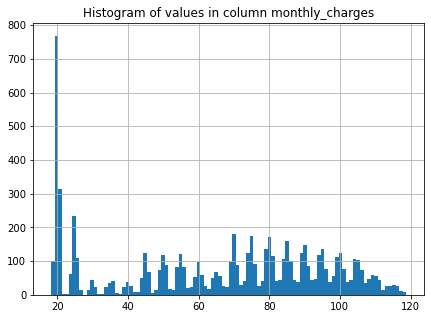

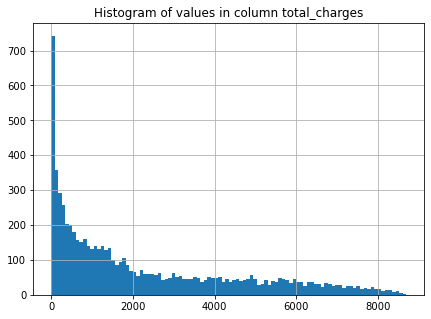

In [62]:
num_cols = ['monthly_charges', 'total_charges']

for col in num_cols:
    plt.figure(figsize=(7,5))
    plt.title(f'Histogram of values in column {col}')
    plt.hist(df[col], bins=100)
    plt.grid()
    plt.show()

Judging by the histograms, there are no values in the dataframe that:
- have significant differences from the majority of the data.

Therefore, I can conclude that there are no anomalies.

### Adding new columns and removing uninformative ones

Let's output the general information about the dataframe and its first and last 5 rows again.

In [63]:
df.info()

df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 7043 non-null   category      
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   contract_type      7043 non-null   category      
 4   e_billing          7043 non-null   int64         
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   int64         
 11  dependents         7043 non-null   int64         
 12  internet_service   7043 non-null   category      
 13  online_security    7043 non-null   int64         
 14  online_b

,id,begin_date,end_date,contract_type,e_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,Female,0,1,0,DSL,0,1,0,0,0,0,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,Male,0,0,0,DSL,1,0,1,0,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,Male,0,0,0,DSL,1,1,0,0,0,0,0,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,Male,0,0,0,DSL,1,0,1,1,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,1,Mailed check,84.80,1990.50,Male,0,1,1,DSL,1,0,1,1,1,1,1,0
7039,2234-XADUH,2014-02-01,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90,Female,0,1,1,Fiber optic,0,1,1,0,1,1,1,0
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45,Female,0,1,1,DSL,1,0,0,0,0,0,0,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,Male,1,1,0,Fiber optic,0,0,0,0,0,0,1,1


To improve the quality of the future training set, I should add a column called duration, which will show how long a person has been/was a customer of the operator.

The uninformative columns are:

- id: does not carry important information for further analysis;
- begin_date and end_date: similarly, were necessary for calculating the duration;
- total_charges: does not carry any semantic load - there is already a monthly_charges column in the dataframe reflecting the monthly cost, and duration reflecting the period during which the client paid.

So, let's add the duration column to the dataframe.

In [64]:
df['duration'] = df['end_date'] - df['begin_date']

df['duration'] = df['duration'].dt.days

Let's remove the uninformative columns.

In [65]:
cols_to_del = ['id', 'begin_date', 'end_date', 'total_charges']

for col in cols_to_del:
    df = df.drop(col, axis=1)

## Exploratory data analysis
### Checking for multicollinearity of features
Let's create a heatmap for the correlation matrix of all the features of the dataframe (except the target).

interval columns not set, guessing: ['e_billing', 'monthly_charges', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'duration']


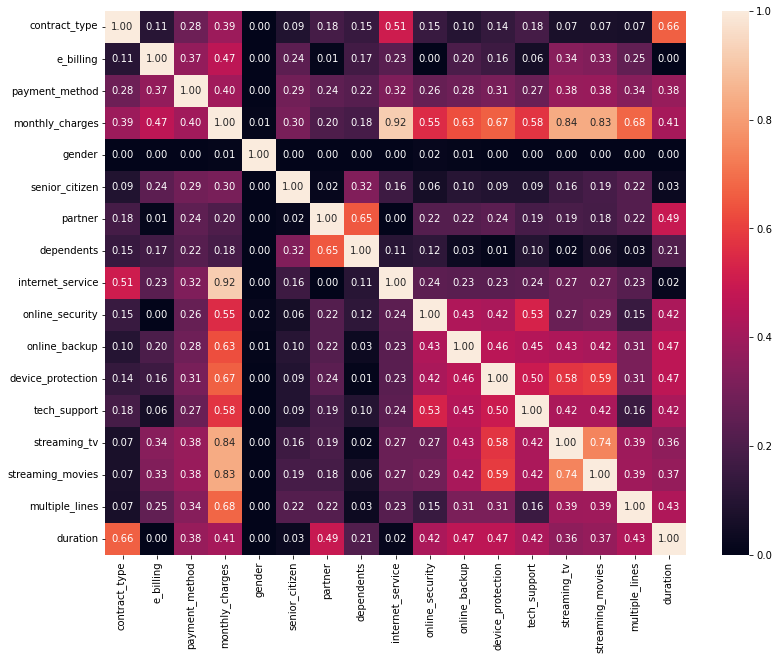

In [66]:
fig, ax = plt.subplots(figsize=(13, 10))

sns.heatmap(df.drop('exited', axis=1).phik_matrix(), 
            annot=True,
            fmt=".2f");

According to the heatmap, there are no noticeable relationships between most of the features. The most noticeable correlations are between the monthly_charges-internet_service, monthly_charges-streaming_tv, and monthly_charges-streaming_movies parameters: 0.92, 0.61, and 0.60, respectively.

|Correlation coefficient magnitude|Relationship characteristic|
|----|----|
|0.9-1|very high|
|0.7-0.9|high|
|0.5-0.7|noticeable|
|0.3-0.5|moderate|
|0.1-0.3|weak|

Thus, only the correlation between monthly_charges and internet_service can be called (very) high.

### Correlation check between the target variable and other features
Let's output a correlation array for the target variable and sort it in descending order by the correlation coefficient value.

In [67]:
pd.DataFrame(
    df.phik_matrix()['exited'].sort_values(ascending=False)
)

interval columns not set, guessing: ['e_billing', 'monthly_charges', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'exited', 'duration']


,exited
exited,1.000000
duration,0.474001
payment_method,0.449125
monthly_charges,0.360050
e_billing,0.295754
online_security,0.264580
tech_support,0.254615
dependents,0.253936
contract_type,0.251639
senior_citizen,0.233432


The target variable does not have any connections with other features that can be called noticeable (with an absolute value of correlation coefficient of 0.5-0.7). The highest correlation coefficients for the target variable are with:

- duration: 0.47
- payment_method: 0.45
- monthly_charges: 0.36

**Conclusion: there are no high correlations between the ordinary features or the target variable with all the others**.

## Preparing data for machine learning
### Checking data for class imbalance

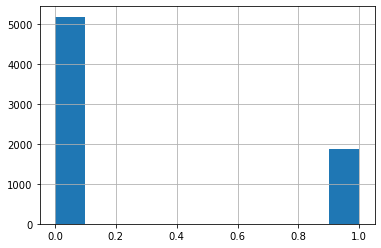

In [68]:
df['exited'].hist();

**There is class imbalance**.

In [69]:
print('Class ratio (0 to 1):',
    df.query('exited == 0')['exited'].count() /
    df.query('exited == 1')['exited'].count()
)

Class ratio (0 to 1): 2.7683253076511503


Considering that the AUC-ROC metric is not sensitive to class imbalance, and given that in this case the imbalance is small, no measures should be taken to address class imbalance.

### Splitting the data into samples

In [70]:
(
    X_train, X_test,
    y_train, y_test
) = train_test_split(df.drop('exited', axis=1),
                    df['exited'],
                    test_size=.25,
                    stratify=df['exited'],
                    random_state=SEED)

### Масштабирование данных

Прежде чем провести стандартизацию данных следует учесть, что разные модели лучше работают с разными данными, а именно:

|Model|Scaling|Encoding|
|----|----|----|
|DecisionTreeClassifier|Yes|One-Hot Encoding|
|RandomForestClassifier|Yes|One-Hot Encoding|
|LogisticRegression|Yes|One-Hot Encoding|
|LGBMClassifier|No|No|
|CatBoostClassifier|No|No|

Thus, the DecisionTree, RandomForest, and LogisticRegression models are better trained on scaled and encoded data, while the others are trained on the original data.



In [71]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled[['monthly_charges', 'duration']] = scaler.fit_transform(X_train[['monthly_charges', 'duration']])
X_test_scaled[['monthly_charges', 'duration']] = scaler.transform(X_test[['monthly_charges', 'duration']])

### Data Encoding
Let's perform data encoding for LogisticRegression using the One-Hot Encoding method.

In [72]:
cat_columns = ['contract_type','payment_method','gender','internet_service']

ohe = OneHotEncoder(handle_unknown='ignore', drop='first')

X_train_preohe = pd.DataFrame(ohe.fit_transform(X_train_scaled[cat_columns]).toarray())
X_test_preohe = pd.DataFrame(ohe.transform(X_test_scaled[cat_columns]).toarray())

X_train_ohe = X_train_scaled.join(X_train_preohe).drop(cat_columns, axis=1).fillna(0)
X_test_ohe = X_test_scaled.join(X_test_preohe).drop(cat_columns, axis=1).fillna(0)

## Machine Learning
I will train and evaluate models:
- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression
- LGBMClassifier
- CatBoostClassifier

### DecisionTreeClassifier

In [73]:
dt = DecisionTreeClassifier(random_state=SEED)

print(dt.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 130223, 'splitter': 'best'}


In [74]:
param_set = {
              'max_depth'        : range(1,11),
              'min_samples_leaf' : [0.04, 0.06, 0.08],
              'max_features'     : [0.2, 0.4, 0.6, 0.8]
            }

grid_dt = GridSearchCV(dt, param_grid=param_set, scoring='roc_auc', cv=10, n_jobs=-1)

In [75]:
%%time

grid_dt.fit(X_train_ohe, y_train)

CPU times: total: 1.52 s
Wall time: 3.39 s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=130223),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': [0.2, 0.4, 0.6, 0.8],
                         'min_samples_leaf': [0.04, 0.06, 0.08]},
             scoring='roc_auc')

In [76]:
dt_best_hyperparams = grid_dt.best_params_
dt_best_score = grid_dt.best_score_

print('Hyperparameters of the best model:\n', dt_best_hyperparams)
print()
print('Best metric value:', dt_best_score)

Hyperparameters of the best model:
 {'max_depth': 6, 'max_features': 0.8, 'min_samples_leaf': 0.04}

Best metric value: 0.8106293999832879


### RandomForestClassifier

In [77]:
rf = RandomForestClassifier(random_state=SEED)

print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 130223, 'verbose': 0, 'warm_start': False}


In [78]:
param_set = {
                'n_estimators'     : [50] + list(range(100,501,100)),
                'max_depth'        : [4,6,8],
                'min_samples_leaf' : [0.1, 0.2],
                'max_features'     : ['log2','sqrt']
            }

grid_rf = GridSearchCV(rf, param_grid=param_set, scoring='roc_auc', cv=10, n_jobs=-1)

In [79]:
%%time

grid_rf.fit(X_train_ohe, y_train)

CPU times: total: 5.14 s
Wall time: 1min 33s


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=130223),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [0.1, 0.2],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='roc_auc')

In [80]:
rf_best_hyperparams = grid_rf.best_params_
rf_best_score = grid_rf.best_score_

print('Hyperparameters of the best model:\n', rf_best_hyperparams)
print()
print('Best metric value:', rf_best_score)

Hyperparameters of the best model:
 {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'n_estimators': 500}

Best metric value: 0.8245888235201955


### Logistic Regression

In [81]:
lr = LogisticRegression(random_state=SEED)

print(lr.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 130223, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [82]:
param_set = {
                'penalty' : ['l1', 'l2'], 
                'C'       : np.logspace(-3,3,7),
                'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
            }

grid_lr = GridSearchCV(lr, param_grid=param_set, scoring='roc_auc', cv=10, n_jobs=-1)

In [83]:
%%time

grid_lr.fit(X_train_ohe, y_train)

CPU times: total: 1.02 s
Wall time: 1.94 s


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=130223),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

In [84]:
lr_best_hyperparams = grid_lr.best_params_
lr_best_score = grid_lr.best_score_

print('Hyperparameters of the best model:\n', lr_best_hyperparams)
print()
print('Best metric value:', lr_best_score)

Hyperparameters of the best model:
 {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Best metric value: 0.8297733029381966


### LGBM Classifier

In [85]:
lgbm = LGBMClassifier(random_state=SEED)

print(lgbm.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 130223, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [86]:
param_set = {
                'num_leaves'    : [14, 21],
                'learning_rate' : [0.01, 0.1],
                'max_depth'     : [5, 7],
                'n_estimators'  : [100, 1000]
            }

grid_lgbm = GridSearchCV(lgbm, param_grid=param_set, scoring='roc_auc', cv=10, n_jobs=-1)

In [87]:
%%time

grid_lgbm.fit(X_train, y_train)

CPU times: total: 6.44 s
Wall time: 18.9 s


GridSearchCV(cv=10, estimator=LGBMClassifier(random_state=130223), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 7],
                         'n_estimators': [100, 1000], 'num_leaves': [14, 21]},
             scoring='roc_auc')

In [88]:
lgbm_best_hyperparams = grid_lgbm.best_params_
lgbm_best_score = grid_lgbm.best_score_

print('Hyperparameters of the best model:\n', lgbm_best_hyperparams)
print()
print('Best metric value:', lgbm_best_score)

Hyperparameters of the best model:
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'num_leaves': 14}

Best metric value: 0.9030130876654237


### CatBoost Classifier

In [89]:
cb = CatBoostClassifier(random_state=SEED)

print(cb.get_params())

{'random_state': 130223}


In [90]:
param_set = {
                'depth'         : [4,7],
                'learning_rate' : [0.02, 0.04],
                'iterations'    : [5,10]
            }

grid_cb = GridSearchCV(cb, param_grid=param_set, scoring='roc_auc', cv=10, n_jobs=-1)

To train the model correctly, I need to pass a list of column numbers with the category data type to the model. Let's create this list.

In [91]:
cat_cols = X_train.select_dtypes(include='category').columns
cols = X_train.columns

cat_cols_num = []

for cat_col in cat_cols:
    for col_num in range(len(cols)):
        if cols[col_num] == cat_col:
            cat_cols_num.append(col_num)
            
cat_cols_num

[0, 2, 4, 8]

In [92]:
%%time

grid_cb.fit(X_train, y_train,
                 cat_features=cat_cols_num)

0:	learn: 0.6773615	total: 186ms	remaining: 1.68s
1:	learn: 0.6620698	total: 218ms	remaining: 872ms
2:	learn: 0.6487463	total: 238ms	remaining: 555ms
3:	learn: 0.6367028	total: 260ms	remaining: 390ms
4:	learn: 0.6255124	total: 273ms	remaining: 273ms
5:	learn: 0.6142453	total: 290ms	remaining: 193ms
6:	learn: 0.6030040	total: 307ms	remaining: 132ms
7:	learn: 0.5928293	total: 325ms	remaining: 81.3ms
8:	learn: 0.5837455	total: 343ms	remaining: 38.1ms
9:	learn: 0.5748597	total: 358ms	remaining: 0us
CPU times: total: 828 ms
Wall time: 5.78 s


GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000235F08FF520>,
             n_jobs=-1,
             param_grid={'depth': [4, 7], 'iterations': [5, 10],
                         'learning_rate': [0.02, 0.04]},
             scoring='roc_auc')

In [93]:
cb_best_hyperparams = grid_cb.best_params_
cb_best_score = grid_cb.best_score_

print('Hyperparameters of the best model:\n', cb_best_hyperparams)
print()
print('Best metric value:', cb_best_score)

Hyperparameters of the best model:
 {'depth': 7, 'iterations': 10, 'learning_rate': 0.04}

Best metric value: 0.8346890373828847


### Метрики моделей

In [94]:
results = pd.DataFrame(
    
    data=[
        dt_best_score,
        rf_best_score,
        lr_best_score,
        lgbm_best_score,
        cb_best_score
    ],
    
    index=[
        'Decision Tree',
        'Random Forest',
        'Logistic Regression',
        'LGBM',
        'Cat Boost'
    ])

display(results.sort_values(by=0, ascending=False))
print(f'The highest metric value - {results[0].max():.3f} \
- у {results[results[0].abs() == results[0].max()].index}')

,0
LGBM,0.903013
Cat Boost,0.834689
Logistic Regression,0.829773
Random Forest,0.824589
Decision Tree,0.810629


The highest metric value - 0.903 - у Index(['LGBM'], dtype='object')


I will test the best version of the LGBM model on the test dataset.

## Testing the model on the test dataset

In [95]:
pred = grid_lgbm.best_estimator_.predict_proba(X_test)
score = roc_auc_score(y_test, pred[:, 1])
print()

if score >= THRESHOLD_AUC_ROC:
    print(f'The AUC-ROC value on the test dataset is {score:.3f}, \
which is higher than the threshold value of {THRESHOLD_AUC_ROC}.\nI successfully completed the task.')
elif score < THRESHOLD_AUC_ROC:
    print(f'The AUC-ROC value on the test dataset is {score:.3f}, \
which is lower than the threshold value of {THRESHOLD_AUC_ROC}.\nThis is a failure.')   


The AUC-ROC value on the test dataset is 0.916, which is higher than the threshold value of 0.85.
I successfully completed the task.


## Feature importance check
Let's plot the importance of each feature.

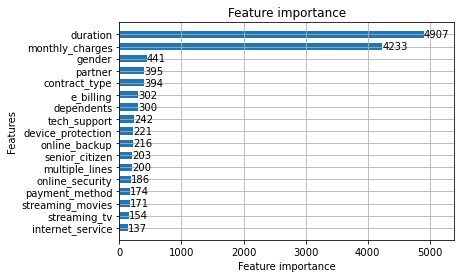

In [96]:
lgb.plot_importance(grid_lgbm.best_estimator_, max_num_features=30, height=.6);

As we can see, the most important features are duration and monthly_charges. Payment_method is also significant.

Interestingly, these three features (duration, payment_method, and monthly_charges) had the highest correlation coefficients with the target variable, namely 0.47, 0.36, and 0.45, respectively. However, according to the table of correlation strengths, these coefficients did not indicate even a noticeable relationship between these features and the target.

**Let's conduct an experiment: I will train the LGBM Classifier model on the training dataset, including only the two best parameters, and test it on a test dataset with the same set of features**.

In [97]:
param_set = {
                'num_leaves'    : [14, 21],
                'learning_rate' : [0.01, 0.1],
                'max_depth'     : [5, 7],
                'n_estimators'  : [100, 1000]
            }

grid_lgbm = GridSearchCV(lgbm, param_grid=param_set, scoring='roc_auc', cv=10, n_jobs=-1)

In [98]:
%%time

grid_lgbm.fit(X_train[['duration', 'monthly_charges']], y_train)

CPU times: total: 3.44 s
Wall time: 11.4 s


GridSearchCV(cv=10, estimator=LGBMClassifier(random_state=130223), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 7],
                         'n_estimators': [100, 1000], 'num_leaves': [14, 21]},
             scoring='roc_auc')

In [99]:
lgbm_best_hyperparams_exp = grid_lgbm.best_params_
lgbm_best_score_exp = grid_lgbm.best_score_

print('Hyperparameters of the best model:\n', lgbm_best_hyperparams_exp)
print()
print('Best metric value:', lgbm_best_score_exp)

Hyperparameters of the best model:
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'num_leaves': 14}

Best metric value: 0.9025415060738048


In [100]:
pred = grid_lgbm.best_estimator_.predict_proba(X_test[['duration', 'monthly_charges']])
score = roc_auc_score(y_test, pred[:, 1])

if score >= THRESHOLD_AUC_ROC:
    print(f'The AUC-ROC value on the test set, including only the two best parameters, is {score:.3f}.')
    print(f'This turned out to be higher than the threshold value of {THRESHOLD_AUC_ROC}.\nI successfully completed the task')
elif score < THRESHOLD_AUC_ROC:
    print(f'The AUC-ROC value on the test set, including only the two best parameters, is {score:.3f}, \
which is below the threshold value of {THRESHOLD_AUC_ROC}.\nThis is a failure.') 

The AUC-ROC value on the test set, including only the two best parameters, is 0.919.
This turned out to be higher than the threshold value of 0.85.
I successfully completed the task


The experiment showed that the two most important features are sufficient to train a high-quality model. Moreover, the AUC-ROC value of this model is even higher than that of the model trained on all features.

## Conclusion

I have successfully completed the task of building a model that accurately predicts whether a customer will leave the telecom operator or not, achieving a metric value of 0.916, which is higher than the threshold of 0.85. With this model, the telecom operator will save a significant amount of money since retaining existing customers is less costly than acquiring new ones.

During the project, I:

- Opened and analyzed the data;
- Developed a plan for further work;
- Conducted data preprocessing, including renaming columns, handling missing values, and changing data types;
- Performed exploratory data analysis to identify the features most correlated with the target variable, which were found to be the most important for the model;
- Prepared the data for machine learning by splitting the data into train and validation sets, scaling the data for logistic regression, and encoding the data;
- Trained Logistic Regression, LGBM Classifier, and Catboost Classifier models and evaluated their performance using the AUC-ROC metric on the validation set, with the LightGBM model having the best performance;
- Tested the best model on the test set, obtaining an AUC-ROC value of 0.916, which is above the threshold of 0.85;
- Identified the most important features, which are duration and monthly_charges;
- Conducted an experiment by training the LGBM Classifier model on a subset of the two best features and testing it on the test set, achieving a slightly higher AUC-ROC value than the model trained on all features.

**Recommendations**: I recommend that the client use the best-performing model, LGBM Classifier, trained on the subset of the two best features, to predict customer churn. The hyperparameters of the best model are:

- 'learning_rate': 0.1,
- 'max_depth': 5,
- 'n_estimators': 1000,
- 'num_leaves': 14.

Therefore, with a model accuracy of around 91.9% on the test set, the client can accurately determine whether a customer will leave and retain them with various gifts or promotions, ultimately saving money that would otherwise be spent on acquiring new customers.